In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point, LineString

1. Import the data located at this link. It has information on people infected with dengue at the district level for 2015 to 2021.

In [2]:
base_dengue = pd.read_csv(r'../../_data/data_dengue_peru.csv',thousands=',', na_values=['NaN', 'nan'], dtype={'Casos': 'float'})

2. Generate ubigeo for Departments and Provinces taking the first two and four numbers. Hint: Use this code.

In [3]:
# Create 'Ubigeo_Departamento', 'Ubigeo_Provincia' and rename 'Ubigeo' to 'Ubigeo_Distrito'
base_dengue['Ubigeo']=base_dengue['Ubigeo'].astype(str).str.zfill(6)
base_dengue['Ubigeo_Departamento'] = base_dengue['Ubigeo'].astype(str).str[:2]
base_dengue['Ubigeo_Provincia'] = base_dengue['Ubigeo'].astype(str).str[:4]
base_dengue = base_dengue.rename(columns={'Ubigeo':'Ubigeo_Distrito'})

In [4]:
# Create data frames 'base_Distrito', 'base_Provincia', and 'base_Departamento' to facilitate the creation of the next plots

# Define the levels we are going to group the columns 'Casos'
nivel = ['Distrito', 'Provincia', 'Departamento']
# Dictionary to store the results
datas = {}
# Loop to create the data frames
for nivel in nivel:
    columna_ubigeo = f'Ubigeo_{nivel}'
    datas[nivel] = base_dengue.groupby([columna_ubigeo, 'Año', nivel ])['Casos'].sum(min_count=0).reset_index()
    
    exec(f"base_{nivel} = datas['{nivel}']")

In [5]:
base_Distrito

,Ubigeo_Distrito,Año,Distrito,Casos
0,010101,2015,CHACHAPOYAS,3.0
1,010101,2016,CHACHAPOYAS,0.0
2,010101,2017,CHACHAPOYAS,0.0
3,010101,2018,CHACHAPOYAS,1.0
4,010101,2019,CHACHAPOYAS,1.0
...,...,...,...,...
3243,250401,2015,PURUS,0.0
3244,250401,2016,PURUS,0.0
3245,250401,2017,PURUS,0.0
3246,250401,2020,PURUS,1.0


In [6]:
# Get geometry information
maps = gpd.read_file(r'../../_data/shape_file/DISTRITOS.shp')

In [7]:
# Keeps geometry information for 'Distrito'
maps_DIST = maps[['IDDIST', 'geometry']]
maps_DIST = maps_DIST.rename({'IDDIST':'Ubigeo_Distrito'}, axis =1 )
maps_DIST['Ubigeo_Distrito'] = maps_DIST['Ubigeo_Distrito'].astype(str)

# Keeps geometry information for 'Provincia'
maps_PROV = maps[['IDPROV', 'geometry']]
maps_PROV = maps_PROV.rename({'IDPROV':'Ubigeo_Provincia'}, axis =1 )
maps_PROV['Ubigeo_Provincia'] = maps_PROV['Ubigeo_Provincia'].astype(str)

# Keeps geometry information for 'Departamento'
maps_DEP = maps[['IDDPTO', 'geometry']]
maps_DEP = maps_DEP.rename({'IDDPTO':'Ubigeo_Departamento'}, axis =1 )
maps_DEP['Ubigeo_Departamento'] = maps_DEP['Ubigeo_Departamento'].astype(str)

3. Use geopandas to plot the number of cases in 2021 by the district using a continuous legend. Do not forget to indicate the color of NA values. Use this shapefile.

In [8]:
#Usamos la base filtrando el año 2021 y la renombramos

base_Distrito_2021 = base_Distrito[base_Distrito["Año"] == 2021]

In [9]:
#Checamos que los valores en las columnas Ubigeo_Distrito son únicas para ambas bases

maps_DIST.Ubigeo_Distrito.is_unique
base_Distrito_2021.Ubigeo_Distrito.is_unique

True

In [10]:
#Checamos que tipos de datos son los valores en ambas bases, con énfasis en Ubigeo_Distrito para hacer el merge

maps_DIST.dtypes
base_Distrito_2021.dtypes

Ubigeo_Distrito     object
Año                  int64
Distrito            object
Casos              float64
dtype: object

In [11]:
#Convertimos los valores de la columna Ubigeo_Distrito en la base_Distrito_2021 a string

base_Distrito_2021.loc[:, 'Ubigeo_Distrito'] = base_Distrito_2021['Ubigeo_Distrito'].astype(str)

In [12]:
#Relizamos el merge, dejando todas las observaciones de la base maps_DIST, lo que nos genera valores NaN.

dataset = pd.merge(maps_DIST, base_Distrito_2021, how = "left", on = "Ubigeo_Distrito" )

In [13]:
#Para poder observar los distintos valores únicos en la columna Casos se realiza una tabla de frecuencias

tabla_frecuencias_casos = dataset['Casos'].value_counts().reset_index()
tabla_frecuencias_casos.columns = ['Número de Casos', 'Frecuencia']
tabla_frecuencias_casos = tabla_frecuencias_casos.sort_values(by='Número de Casos')

tabla_frecuencias_casos

,Número de Casos,Frecuencia
0,0.0,96
1,1.0,40
2,2.0,31
7,3.0,9
4,4.0,18
...,...,...
115,914.0,1
76,1535.0,1
75,1861.0,1
88,2228.0,1


In [14]:
!pip install --upgrade mapclassify

<Axes: >

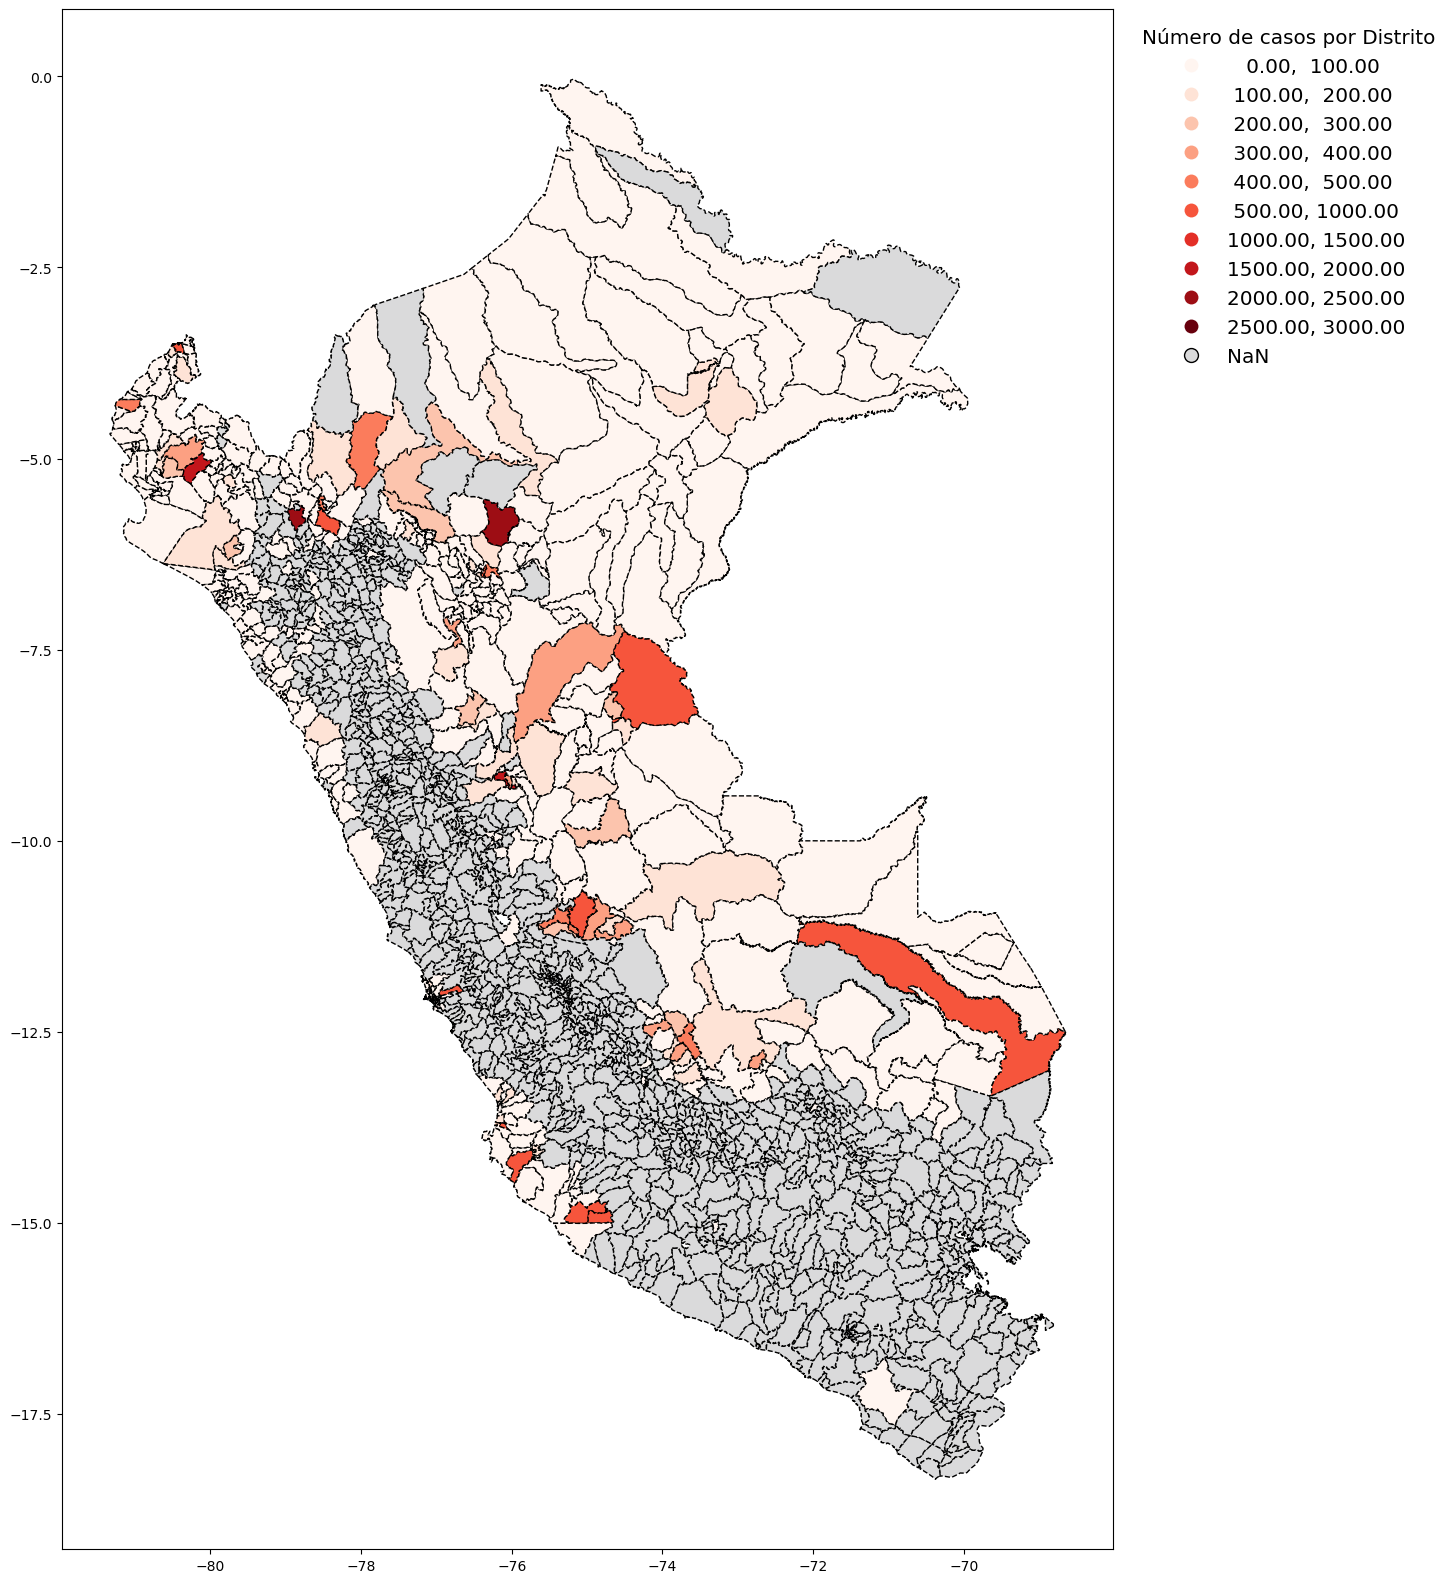

In [15]:
#Se hace el mapeo considerando un colo diferente para los valores NaN

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 20))
dataset.plot(ax = ax, 
        column='Casos', 
         cmap= 'Reds', 
         figsize=(20, 20), 
         linestyle='--',
         edgecolor='black', 
         legend = True,  
         scheme = "User_Defined", 
         missing_kwds= dict(color = "#DADADB",), 
         classification_kwds = dict( bins = [ 100, 200, 300, 400, 500, 1000, 1500, 2000,  2500, 3000 ] ), 
         legend_kwds=dict(  loc='upper left',
                            bbox_to_anchor=(1.01, 1),
                            fontsize='x-large',
                            title= "Número de casos por Distrito", 
                            title_fontsize = 'x-large', 
                            frameon= False )
            )

4. Use geopandas to plot the number of cases in 2021 by the province using a continuous legend. Do not forget to indicate the color of NA values. Use this shapefile. For this task, you will have to aggregate shapefiles at the province level.

In [16]:
# import matplotlib.pyplot as plt

In [17]:
# Create new dataframe by filtering province data by year = 2021

base_Prov_2021 = base_Provincia[base_Provincia["Año"] == 2021]
base_Prov_2021

,Ubigeo_Provincia,Año,Provincia,Casos
6,0101,2021,CHACHAPOYAS,0.0
13,0102,2021,BAGUA,676.0
20,0103,2021,BONGARA,0.0
27,0104,2021,CONDORCANQUI,435.0
34,0107,2021,UTCUBAMBA,719.0
...,...,...,...,...
611,2403,2021,ZARUMILLA,72.0
618,2501,2021,CORONEL PORTILLO,1241.0
625,2502,2021,ATALAYA,179.0
632,2503,2021,PADRE ABAD,193.0


In [18]:
# Create new shapefile file where we aggregate district geometry at province level
maps_PROV1 = maps_PROV.dissolve( by = 'Ubigeo_Provincia' )
maps_PROV1.reset_index(drop=False, inplace=True) # Reset index to maintain 'Ubigeo_Provincia' column
# Show new province level geometry shapefiles
# fig, ax = plt.subplots( figsize = ( 12, 15 ) )
# maps_PROV1.plot( ax = ax )

In [19]:
# Check for unique values in both geometry and values dataframes
print(maps_PROV1.Ubigeo_Provincia.is_unique)
print(base_Prov_2021.Ubigeo_Provincia.is_unique)
# Also, check 'Ubigeo_Provincia' column contains same type values on both dataframes
print(base_Prov_2021.dtypes)
print(maps_PROV1.dtypes)

True
True
Ubigeo_Provincia     object
Año                   int64
Provincia            object
Casos               float64
dtype: object
Ubigeo_Provincia      object
geometry            geometry
dtype: object


In [20]:
# Merge dataframes
prov_df = pd.merge(maps_PROV1, base_Prov_2021, how = "left", on = "Ubigeo_Provincia" )
prov_df

,Ubigeo_Provincia,geometry,Año,Provincia,Casos
0,0101,"POLYGON ((-77.78428 -6.94651, -77.78553 -6.948...",2021.0,CHACHAPOYAS,0.0
1,0102,"POLYGON ((-78.32261 -5.57401, -78.32193 -5.575...",2021.0,BAGUA,676.0
2,0103,"POLYGON ((-77.93906 -6.03766, -77.93973 -6.037...",2021.0,BONGARA,0.0
3,0104,"POLYGON ((-77.58527 -4.47289, -77.58594 -4.475...",2021.0,CONDORCANQUI,435.0
4,0105,"POLYGON ((-77.93702 -6.69093, -77.93914 -6.693...",NaN,NaN,NaN
...,...,...,...,...,...
191,2403,"POLYGON ((-80.19465 -3.62601, -80.19313 -3.625...",2021.0,ZARUMILLA,72.0
192,2501,"POLYGON ((-73.27613 -9.68486, -73.27596 -9.685...",2021.0,CORONEL PORTILLO,1241.0
193,2502,"POLYGON ((-72.48277 -10.79495, -72.48263 -10.7...",2021.0,ATALAYA,179.0
194,2503,"POLYGON ((-75.11866 -8.90145, -75.11869 -8.902...",2021.0,PADRE ABAD,193.0


In [21]:
# Check 'Casos' values frecuency

prov_casos = prov_df['Casos'].value_counts().reset_index()
prov_casos.columns = ['Número de Casos', 'Frecuencia']
prov_casos = prov_casos.sort_values(by='Número de Casos')

prov_casos

,Número de Casos,Frecuencia
0,0.0,17
2,1.0,3
4,2.0,2
45,3.0,1
3,4.0,2
...,...,...
61,1897.0,1
53,2290.0,1
7,2363.0,1
47,2386.0,1


<Axes: >

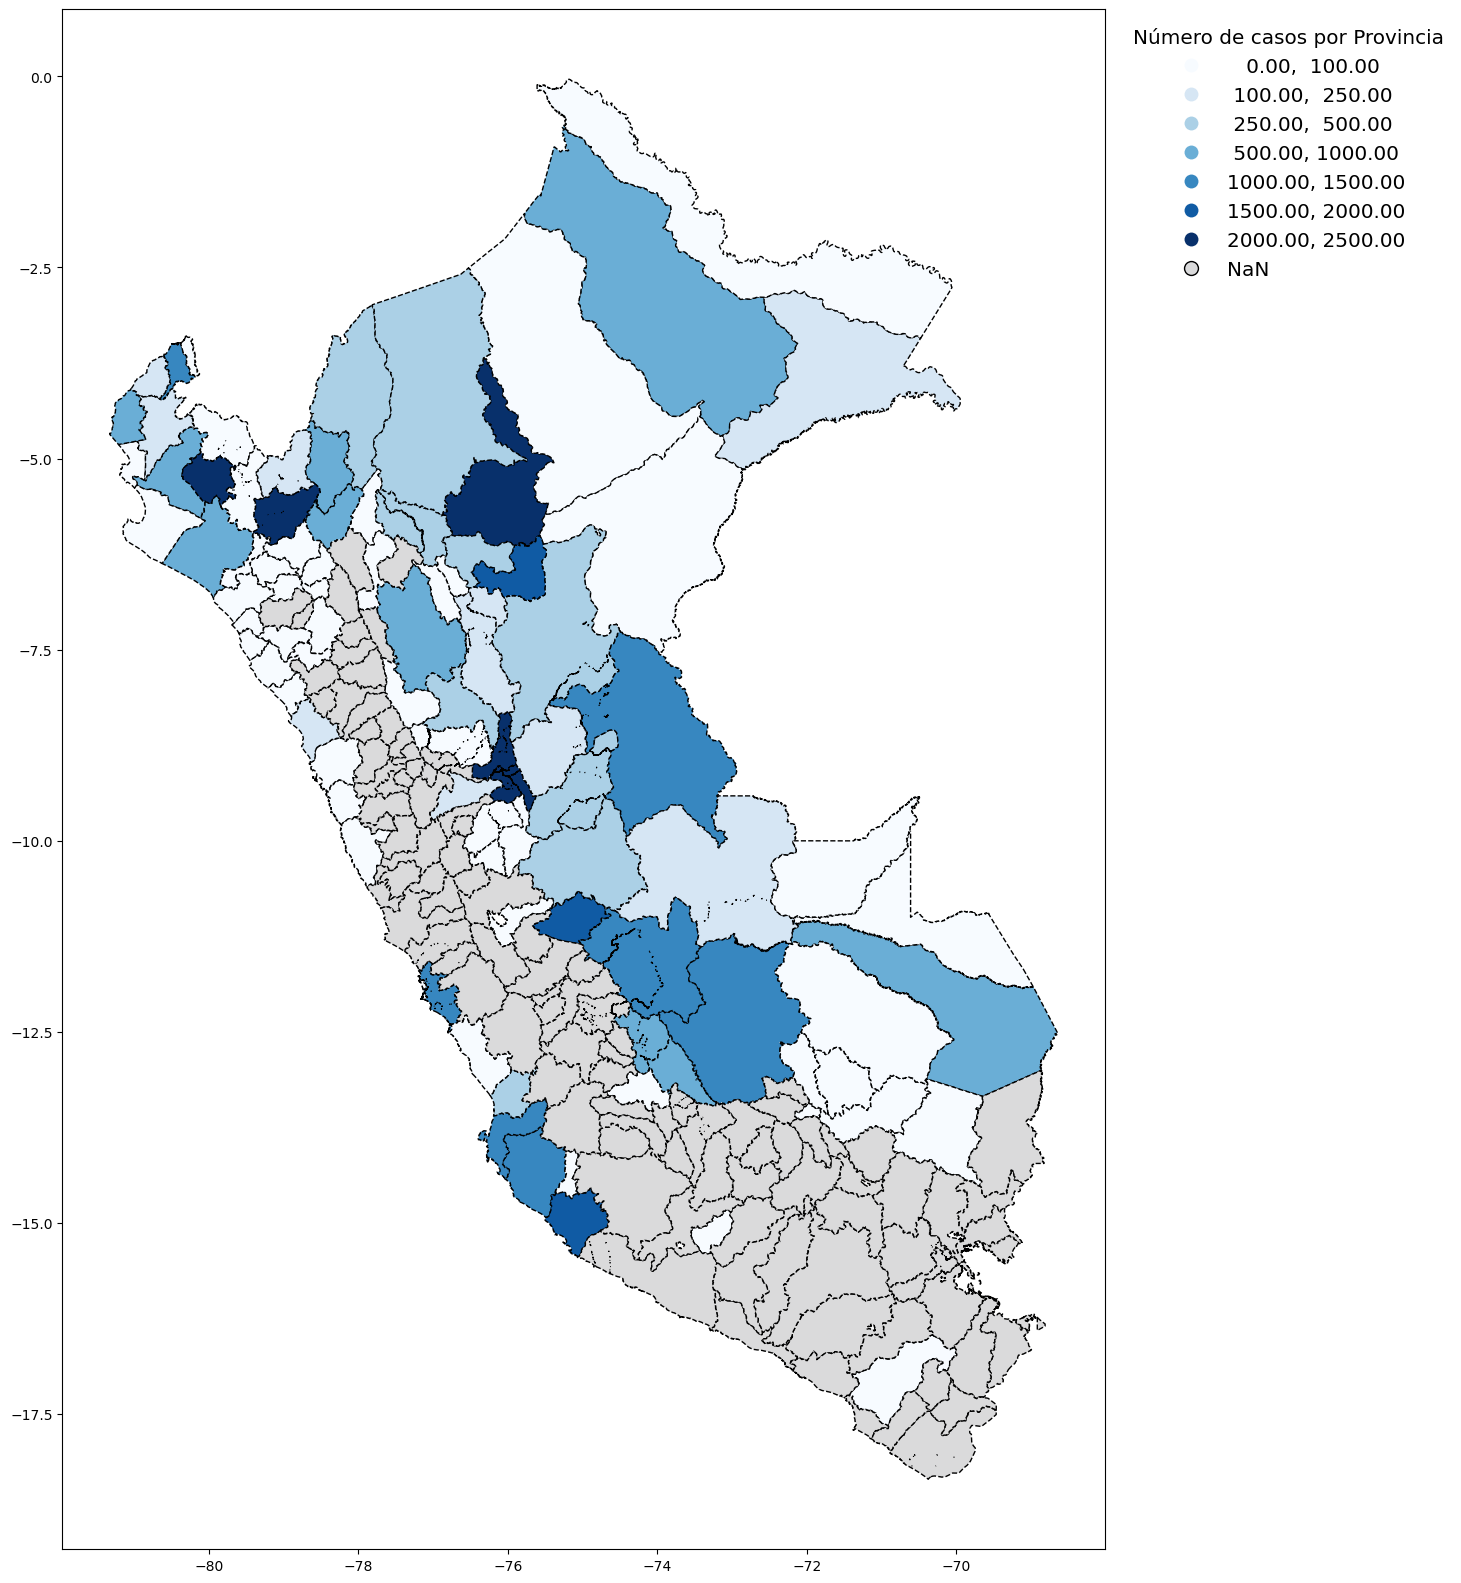

In [22]:
# Plot map, consider value frecuency to establish bins for continous legend
fig, ax = plt.subplots(figsize=(20, 20))
prov_df.plot(ax = ax, 
        column='Casos', 
         cmap= 'Blues', 
         figsize=(20, 20), 
         linestyle='--',
         edgecolor='black', 
         legend = True,  
         scheme = "User_Defined", 
         missing_kwds= dict(color = "#DADADB",), 
         classification_kwds = dict( bins = [100, 250, 500, 1000, 1500, 2000, 2500] ), 
         legend_kwds=dict(  loc='upper left',
                            bbox_to_anchor=(1.01, 1),
                            fontsize='x-large',
                            title= "Número de casos por Provincia", 
                            title_fontsize = 'x-large', 
                            frameon= False )
            )

6. Use geopandas to plot the number of cases by the department for all 2021 quarters using subplots. Every subplot for each quarter. Use a categorical legend with 5 bins. Do not forget to indicate the color of NA values. Use this shapefile. For this task, you will have to aggregate shapefiles at the department level. Hint: Use Semana variable to group by quarters.


In [23]:
# we call the initial database
base_dengue

# Function to map weeks to quarters
def weeks_to_quarters(week):
    if week <= 13:
        return 'Q1'
    elif week <= 26:
        return 'Q2'
    elif week <= 39:
        return 'Q3'
    else:
        return 'Q4'

# Apply the function to create a new column 'Trimestres'
base_dengue['Trimestres'] = base_dengue['Semana'].apply(weeks_to_quarters)

base_dengue

# We group the number of cases by department location, department, year and quarters
base_dpto = base_dengue.groupby(['Ubigeo_Departamento', 'Departamento', 'Año', 'Trimestres'])['Casos'].sum(min_count=0).reset_index()


# We keep with observartions for year 2021
base_Departamento_2021 = base_dpto[base_dpto["Año"] == 2021]
base_Departamento_2021

,Ubigeo_Departamento,Departamento,Año,Trimestres,Casos
24,01,AMAZONAS,2021,Q1,599.0
25,01,AMAZONAS,2021,Q2,609.0
26,01,AMAZONAS,2021,Q3,583.0
27,01,AMAZONAS,2021,Q4,39.0
52,02,ANCASH,2021,Q1,3.0
...,...,...,...,...,...
559,24,TUMBES,2021,Q4,14.0
584,25,UCAYALI,2021,Q1,923.0
585,25,UCAYALI,2021,Q2,214.0
586,25,UCAYALI,2021,Q3,424.0


In [24]:
# Create new shapefile file where we aggregate district geometry at department level
maps_DEP1 = maps_DEP.dissolve( by = 'Ubigeo_Departamento' )
maps_DEP1.reset_index(drop=False, inplace=True)
maps_DEP1

,Ubigeo_Departamento,geometry
0,01,"POLYGON ((-78.03480 -6.74216, -78.03437 -6.741..."
1,02,"POLYGON ((-77.70189 -10.32392, -77.70434 -10.3..."
2,03,"POLYGON ((-73.51174 -14.53852, -73.51368 -14.5..."
3,04,"POLYGON ((-72.72968 -16.64631, -72.73106 -16.6..."
4,05,"POLYGON ((-74.50284 -15.16064, -74.50360 -15.1..."
5,06,"POLYGON ((-79.07326 -7.46865, -79.08528 -7.462..."
6,07,"POLYGON ((-77.10504 -12.07191, -77.10599 -12.0..."
7,08,"POLYGON ((-71.89418 -14.78954, -71.89579 -14.7..."
8,09,"POLYGON ((-75.26012 -14.04196, -75.26102 -14.0..."
9,10,"POLYGON ((-76.80833 -10.39296, -76.81024 -10.3..."


In [25]:
# Check for unique values in both geometry and values dataframes
print(maps_DEP1.Ubigeo_Departamento.is_unique)
print(base_Departamento_2021.Ubigeo_Departamento.is_unique)
# Also, check 'Ubigeo_Provincia' column contains same type values on both dataframes
print(base_Departamento_2021.dtypes)
print(maps_DEP1.dtypes)

True
False
Ubigeo_Departamento     object
Departamento            object
Año                      int64
Trimestres              object
Casos                  float64
dtype: object
Ubigeo_Departamento      object
geometry               geometry
dtype: object


In [26]:
# Merge dataframes
dep_df = pd.merge(maps_DEP1, base_Departamento_2021, how = "left", on = "Ubigeo_Departamento" )
dep_df

,Ubigeo_Departamento,geometry,Departamento,Año,Trimestres,Casos
0,01,"POLYGON ((-78.03480 -6.74216, -78.03437 -6.741...",AMAZONAS,2021.0,Q1,599.0
1,01,"POLYGON ((-78.03480 -6.74216, -78.03437 -6.741...",AMAZONAS,2021.0,Q2,609.0
2,01,"POLYGON ((-78.03480 -6.74216, -78.03437 -6.741...",AMAZONAS,2021.0,Q3,583.0
3,01,"POLYGON ((-78.03480 -6.74216, -78.03437 -6.741...",AMAZONAS,2021.0,Q4,39.0
4,02,"POLYGON ((-77.70189 -10.32392, -77.70434 -10.3...",ANCASH,2021.0,Q1,3.0
...,...,...,...,...,...,...
83,24,"POLYGON ((-80.39847 -3.98043, -80.39861 -3.980...",TUMBES,2021.0,Q4,14.0
84,25,"POLYGON ((-75.12008 -8.90434, -75.12004 -8.904...",UCAYALI,2021.0,Q1,923.0
85,25,"POLYGON ((-75.12008 -8.90434, -75.12004 -8.904...",UCAYALI,2021.0,Q2,214.0
86,25,"POLYGON ((-75.12008 -8.90434, -75.12004 -8.904...",UCAYALI,2021.0,Q3,424.0


In [27]:
# We use a categorical legend with 5 bins
bins = pd.qcut( dep_df[ 'Casos' ], 5, retbins = True )[ 1 ][ 1: ]
type(bins)


numpy.ndarray

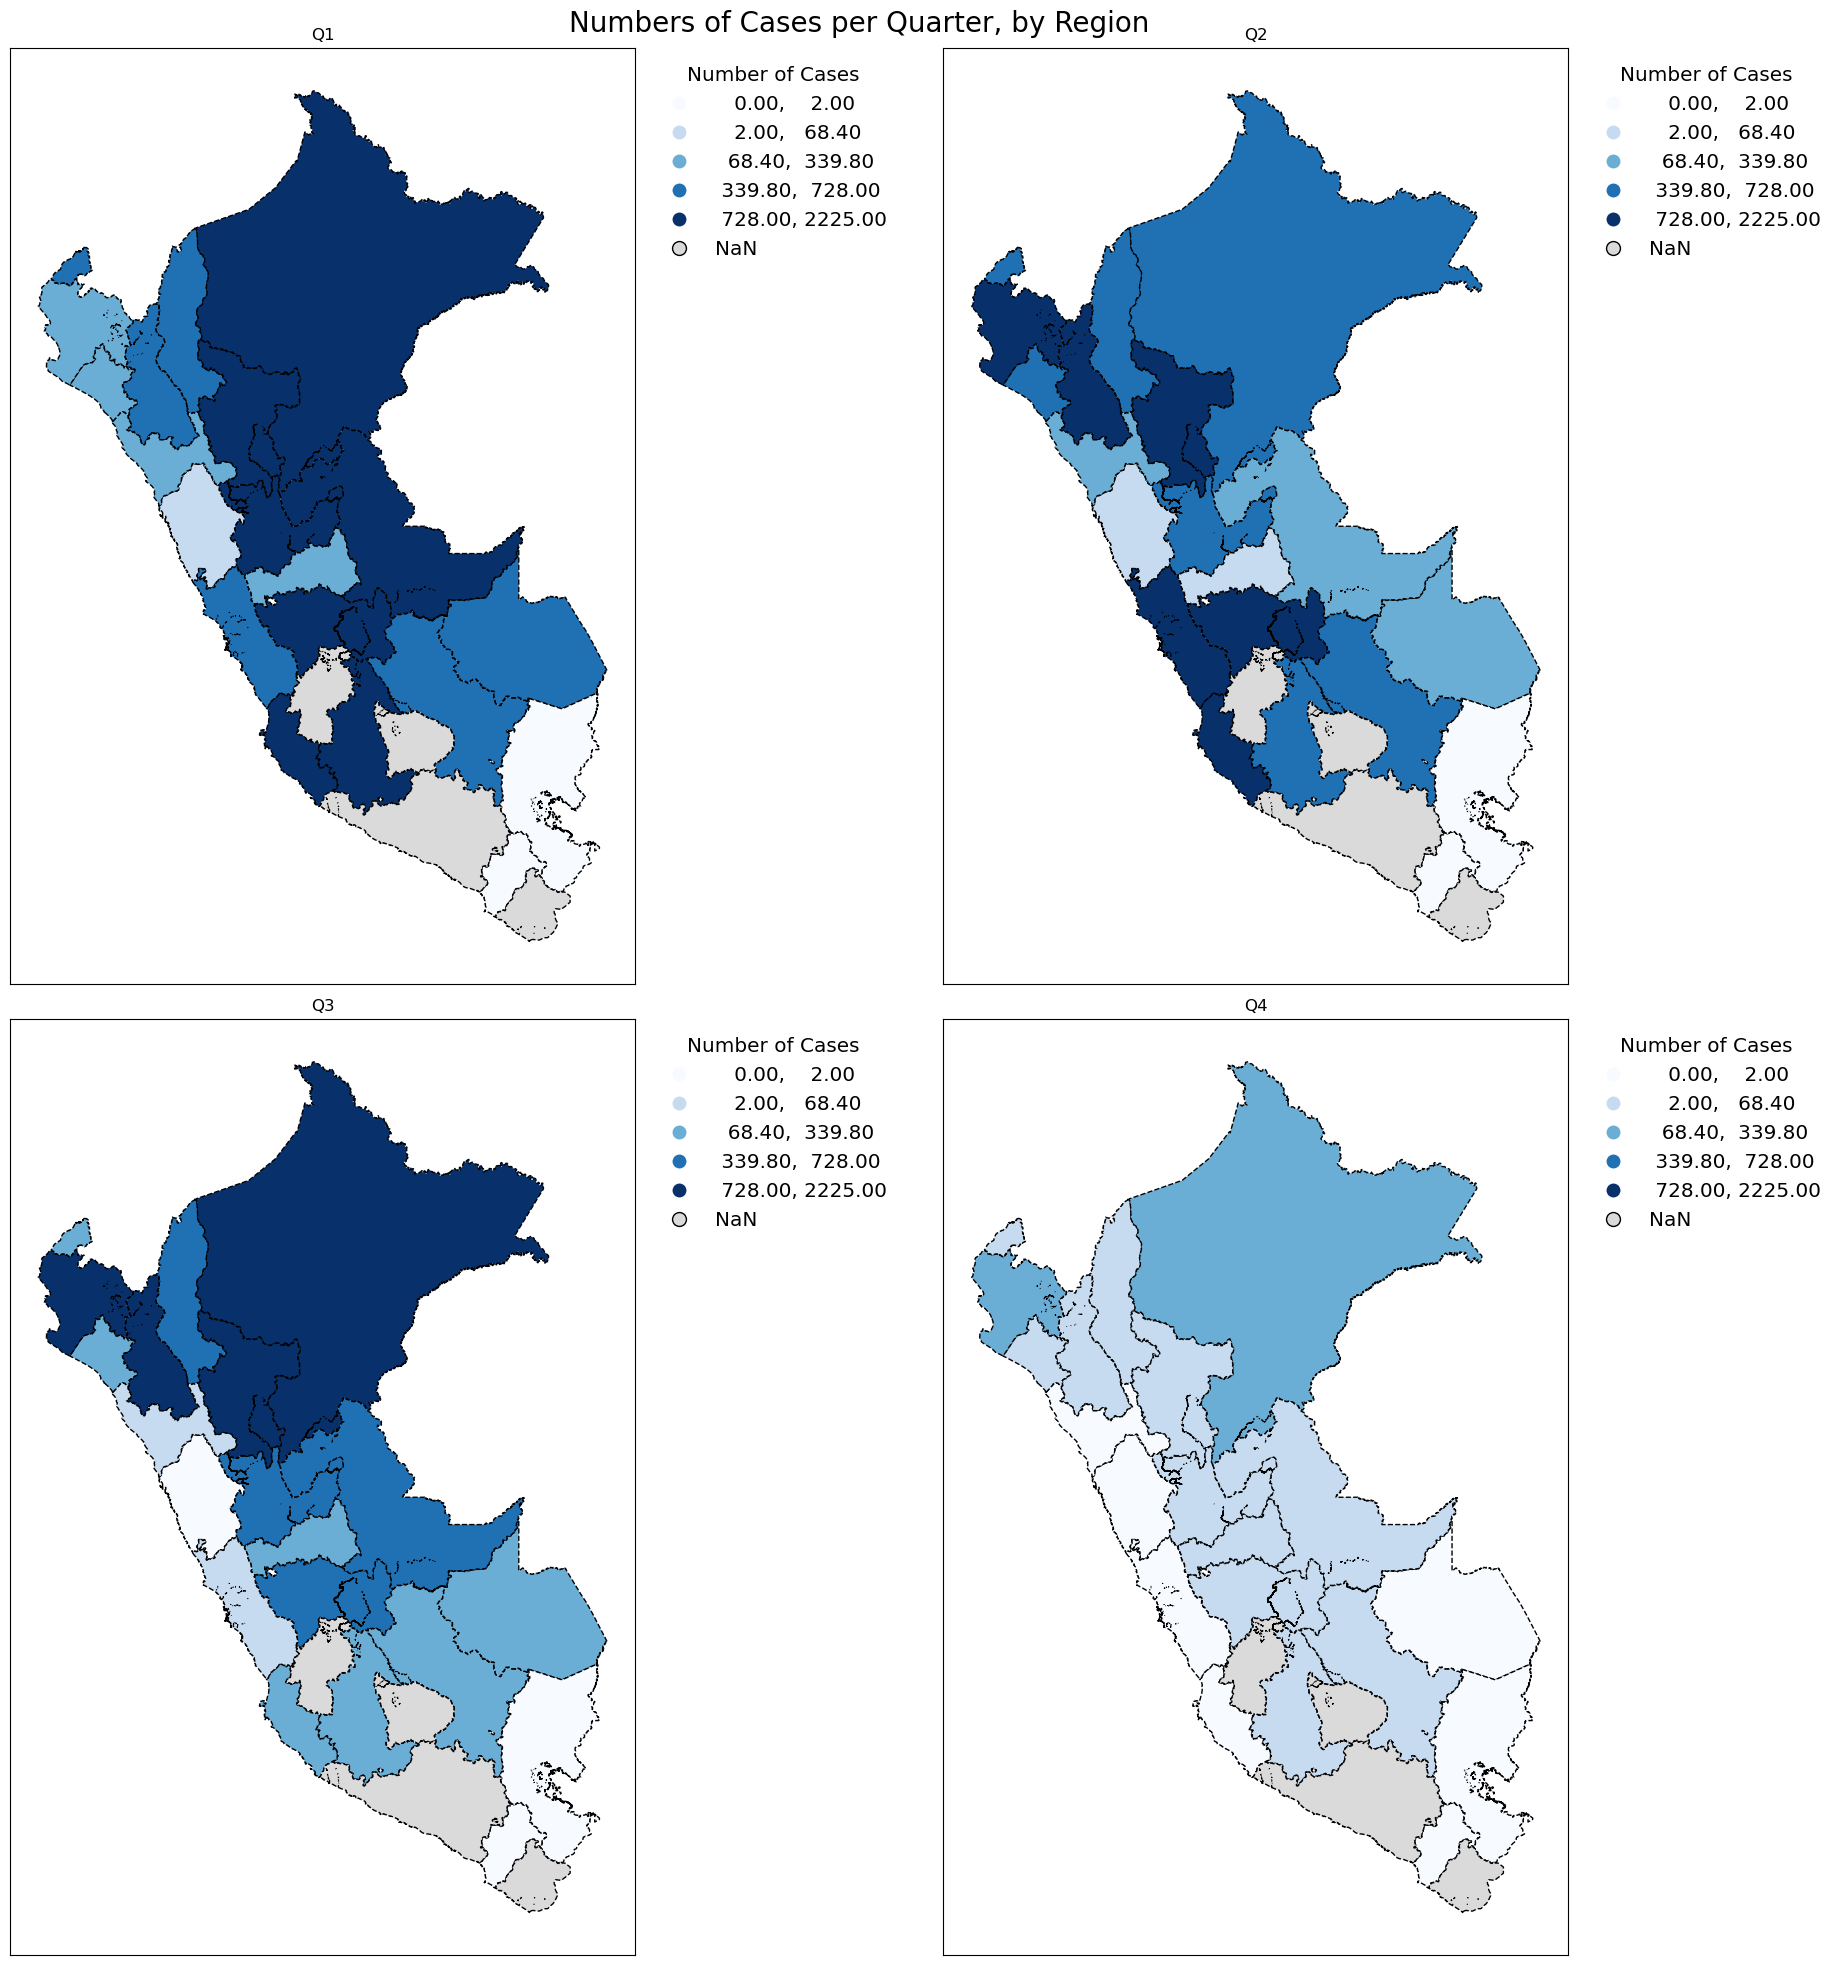

In [28]:
fig, axis = plt.subplots( nrows = 2, ncols = 2, figsize = ( 20, 20 ) )

idx = 0

for i in range( 2 ):
    for j in range( 2 ):
        ax = axis[ i ][ j ]
        cmap = plt.cm.Blues
        quarter = dep_df.Trimestres.unique()[ idx ]
        dg_temp = dep_df[ ( ( dep_df[ 'Trimestres' ] == quarter ) | ( dep_df[ 'Trimestres' ].isna() ) ) ]
        dg_temp.plot( column = 'Casos', cmap = cmap, linestyle = '--', edgecolor = 'black', ax = ax, legend = True, 
                      scheme = 'User_defined',
                      missing_kwds = dict( color = '#DADADB' ), 
                      classification_kwds = dict( bins = bins ), 
                      legend_kwds = dict( loc = 'upper left', bbox_to_anchor = ( 1.01, 1 ), title = 'Number of Cases', 
                                          frameon = False, fontsize = 'x-large', title_fontsize = 'x-large' ) )
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.set_title( f"Q{ str( quarter )[ 0 ] }" )
        ax.set_title( f"Q{idx+1}" )
        idx = idx + 1
fig.suptitle( 'Numbers of Cases per Quarter, by Region', fontsize = 20 )
fig.tight_layout()